In [1]:
from pathlib import Path

import torch
import numpy as np
import pandas as pd

In [2]:
import logging
logging.getLogger().setLevel(logging.INFO)

## Set important local paths

Set your root directory:

In [3]:
ROOT_DIR = Path("~").expanduser().resolve()     # LOCAL dir
# ROOT_DIR = Path("/fast/groups/sf")            # CLUSTER dir
ROOT_DIR

PosixPath('/Users/acruz')

Directory where LLMs are saved:

In [4]:
MODELS_DIR = ROOT_DIR / "huggingface-models"

Directory where data is saved (or will be saved to):

In [5]:
DATA_DIR = ROOT_DIR / "data"

Other configs:

In [6]:
# MODEL_NAME = "meta-llama/Meta-Llama-3-8B"
# MODEL_NAME = "meta-llama/Meta-Llama-3-8B-Instruct"
MODEL_NAME = "google/gemma-2b"    # NOTE: this is among the smallest models

TASK_NAME = "ACSIncome"

RESULTS_ROOT_DIR = ROOT_DIR / "folktexts-results"

In [7]:
from folktexts.llm_utils import load_model_tokenizer, get_model_folder_path
model_folder_path = get_model_folder_path(model_name=MODEL_NAME, root_dir=MODELS_DIR)
model, tokenizer = load_model_tokenizer(model_folder_path)

INFO:root:Got both `value_map` and `question` for column 'PUBCOV'. Please make sure value mappings are consistent.
INFO:root:Got both `value_map` and `question` for column 'PUBCOV==1'. Please make sure value mappings are consistent.
INFO:root:Loading model '/Users/acruz/huggingface-models/google--gemma-2b'
Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Moving model to device: mps


In [8]:
results_dir = RESULTS_ROOT_DIR / Path(model_folder_path).name
results_dir.mkdir(exist_ok=True, parents=True)
results_dir

PosixPath('/Users/acruz/folktexts-results/google--gemma-2b')

### Construct LLM Classifier

Load prediction task (which maps tabular data to text):

In [9]:
from folktexts.acs import ACSTaskMetadata
task = ACSTaskMetadata.get_task(TASK_NAME)

In [10]:
from folktexts.classifier import LLMClassifier
llm_clf = LLMClassifier(
    model=model,
    tokenizer=tokenizer,
    task=task,
    batch_size=32,
)

### Load Dataset

In [11]:
%%time
from folktexts.acs import ACSDataset
dataset = ACSDataset.make_from_task(task=task, cache_dir=DATA_DIR)

Loading ACS data...
CPU times: user 44.3 s, sys: 14.5 s, total: 58.8 s
Wall time: 1min 4s


Optionally, subsample to quickly get approximate results:

In [12]:
dataset.subsample(0.001)
print(f"{dataset.subsampling=}")

INFO:root:Subsampled dataset to 0.1% of the original size. Train size: 1498, Test size: 166, Val size: 0;


dataset.subsampling=0.001


### Load and run ACS Benchmark

**_Note:_** Helper constructors exist at `CalibrationBenchmark.make_acs_benchmark` and `CalibrationBenchmark.make_benchmark` that avoid the above boilerplate code.

In [13]:
from folktexts.benchmark import CalibrationBenchmark, BenchmarkConfig

bench = CalibrationBenchmark(
    llm_clf=llm_clf,
    dataset=dataset,
    config=BenchmarkConfig.default_config(),
)

INFO:root:
** Benchmark initialization **
Model: google--gemma-2b;
Task: ACSIncome;
Hash: 1609974119;



Print a few example prompts:

In [14]:
dataset.task

ACSTaskMetadata(name='ACSIncome', description="predict whether an individual's income is above $50,000", features=['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX', 'RAC1P'], target='PINCP', cols_to_text={'AGEP': <folktexts.col_to_text.ColumnToText object at 0x14a6f2910>, 'COW': <folktexts.col_to_text.ColumnToText object at 0x14a6f2790>, 'SCHL': <folktexts.col_to_text.ColumnToText object at 0x14a6f3810>, 'MAR': <folktexts.col_to_text.ColumnToText object at 0x14a70ca90>, 'OCCP': <folktexts.col_to_text.ColumnToText object at 0x14a70cdd0>, 'POBP': <folktexts.col_to_text.ColumnToText object at 0x14a70ce10>, 'RELP': <folktexts.col_to_text.ColumnToText object at 0x14a70ce50>, 'WKHP': <folktexts.col_to_text.ColumnToText object at 0x14a70d9d0>, 'SEX': <folktexts.col_to_text.ColumnToText object at 0x14a70da50>, 'RAC1P': <folktexts.col_to_text.ColumnToText object at 0x14a70de50>, 'PINCP': <folktexts.col_to_text.ColumnToText object at 0x14a70e490>, 'PINCP>50000': <folktexts.col

In [15]:
X_sample, _y_sample = dataset.sample_n_train_examples(n=5)
X_sample

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
1815911,31,1.0,16.0,1,4700.0,49,0,45.0,1,1
1699859,42,1.0,9.0,5,4251.0,303,0,40.0,1,8
1658375,61,1.0,19.0,3,8130.0,29,0,40.0,1,1
2347220,47,1.0,19.0,5,8740.0,40,0,50.0,1,1
2260528,38,1.0,18.0,1,8130.0,39,1,50.0,1,1


In [16]:
X_sample, _y_sample = dataset.sample_n_train_examples(n=5)
q = llm_clf.task.question

data_texts_batch = [
    llm_clf.encode_row(row, question=q)
    for _, row in X_sample.iterrows()
]

for elem in data_texts_batch:
    print(elem)
    print("*****")

The following data corresponds to a survey respondent. The survey was conducted among US residents in 2018. Please answer the question based on the information provided. The data provided is enough to reach an approximate answer.

Information:
- The age is: 51 years old.
- The class of worker is: Working for a for-profit private company or organization.
- The highest educational attainment is: Regular high school diploma.
- The marital status is: Separated.
- The occupation is: Maids and housekeeping cleaners.
- The place of birth is: Turkey.
- The relationship to the reference person in the survey is: The reference person itself.
- The usual number of hours worked per week is: 14 hours.
- The sex is: Female.
- The race is: White.

Question: What is this person's estimated yearly income?
A. Below $50,000.
B. Above $50,000.
Answer:
*****
The following data corresponds to a survey respondent. The survey was conducted among US residents in 2018. Please answer the question based on the inf

Optionally, you can fit the model's threshold on a few data samples.

This is generally quite fast as it is _not fine-tuning_; it only changes one parameter: the `llm_clf.threshold`.

In [17]:
%%time
X_sample, y_sample = dataset.sample_n_train_examples(n=10)
llm_clf.fit(X_sample, y_sample, context_size=1000)

Computing risk estimates:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:Set threshold to 0.5185365149211257.


CPU times: user 338 ms, sys: 1.99 s, total: 2.33 s
Wall time: 9.68 s


LLMClassifier(encode_row=functools.partial(<function encode_row_prompt at 0x30c044720>, task=ACSTaskMetadata(name='ACSIncome', description="predict whether an individual's income is above $50,000", features=['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX', 'RAC1P'], target='PINCP', cols_to_text={'AGEP': <folktexts.col_to_text.ColumnToText object at 0x14a6f...
	213: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	214: AddedToken("</sub>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	215: AddedToken("</sup>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	216: AddedToken("</code>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
})

Run benchmark...

In [18]:
%%time
bench.run(results_root_dir=results_dir)

INFO:root:Test data features shape: (166, 10)


Computing risk estimates:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:root:
** Test results **
Model: google--gemma-2b;
	 ECE:       7.6%;
	 ROC AUC :  79.9%;
	 Accuracy:  72.3%;
	 Bal. acc.: 70.3%;

INFO:root:Skipping group 'American Indian' as it's too small.
INFO:root:Saving JSON file to '/Users/acruz/folktexts-results/google--gemma-2b/google--gemma-2b_bench-3421378798/results.bench-3421378798.json'
INFO:root:Saved experiment results to '/Users/acruz/folktexts-results/google--gemma-2b/google--gemma-2b_bench-3421378798/results.bench-3421378798.json'


CPU times: user 4.9 s, sys: 39.6 s, total: 44.5 s
Wall time: 4min 3s


0.07605460140229095

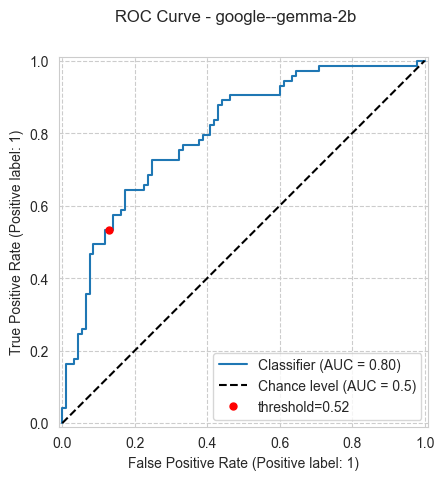

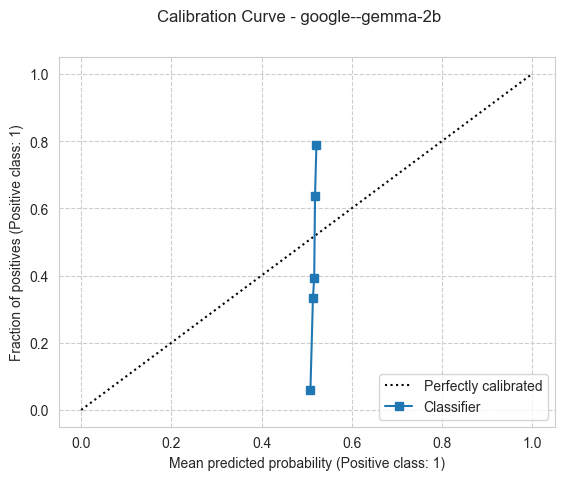

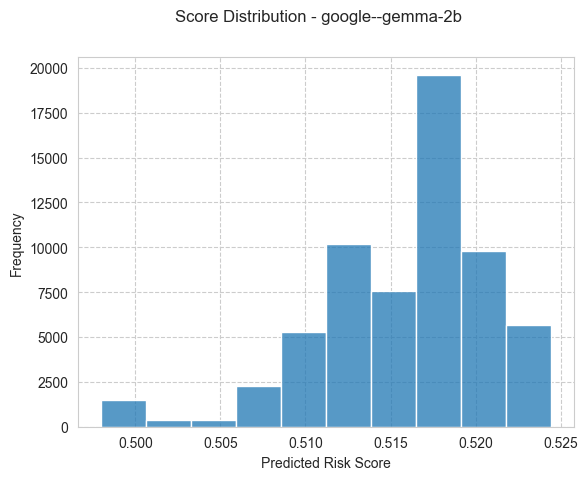

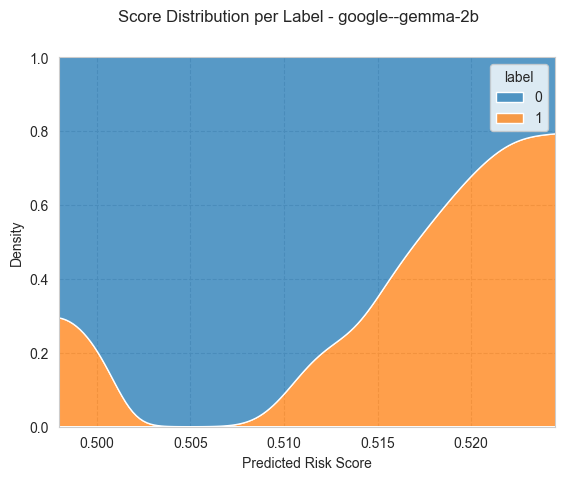

INFO:root:Skipping group 'American Indian' as it's too small.


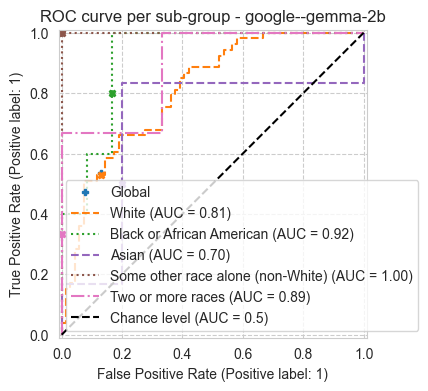

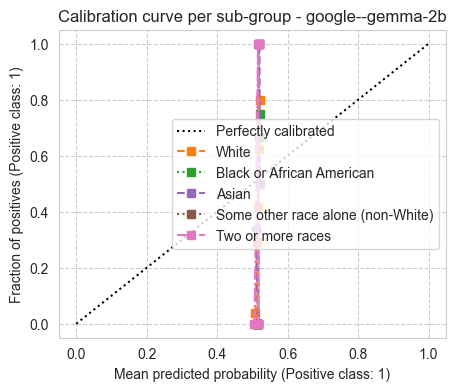

In [19]:
bench.plot_results();

In [20]:
from pprint import pprint
pprint(bench.results, depth=1)

{'accuracy': 0.7228915662650602,
 'accuracy_diff': 0.5,
 'accuracy_ratio': 0.5,
 'balanced_accuracy': 0.7026071586389748,
 'balanced_accuracy_diff': 0.75,
 'balanced_accuracy_ratio': 0.25,
 'brier_score_loss': 0.24991109606400885,
 'config': {...},
 'ece': 0.07605460140229095,
 'ece_quantile': 0.23222924104003553,
 'equalized_odds_diff': 1.0,
 'equalized_odds_ratio': 0.0,
 'fnr': 0.4657534246575342,
 'fnr_diff': 0.6666666666666666,
 'fnr_ratio': 0.0,
 'fpr': 0.12903225806451613,
 'fpr_diff': 1.0,
 'fpr_ratio': 0.0,
 'log_loss': 0.6929668771336814,
 'model_name': 'google--gemma-2b',
 'n_negatives': 93,
 'n_positives': 73,
 'n_samples': 166,
 'plots': {...},
 'ppr': 0.3072289156626506,
 'ppr_diff': 0.3,
 'ppr_ratio': 0.4,
 'precision': 0.7647058823529411,
 'precision_diff': 0.33333333333333337,
 'precision_ratio': 0.6666666666666666,
 'predictions_path': '/Users/acruz/folktexts-results/google--gemma-2b/google--gemma-2b_bench-3421378798/ACSIncome_subsampled-0.001_seed-42_hash-3607287350.t

---